In [1]:
from nilearn import datasets, image, masking
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset (only 1 subject for quick analysis)
dataset = datasets.fetch_development_fmri(n_subjects=1, verbose=1)

# Get fMRI data (first subject)
fmri_img = dataset.func[0]
confounds = dataset.confounds[0]  # Motion-related confounds


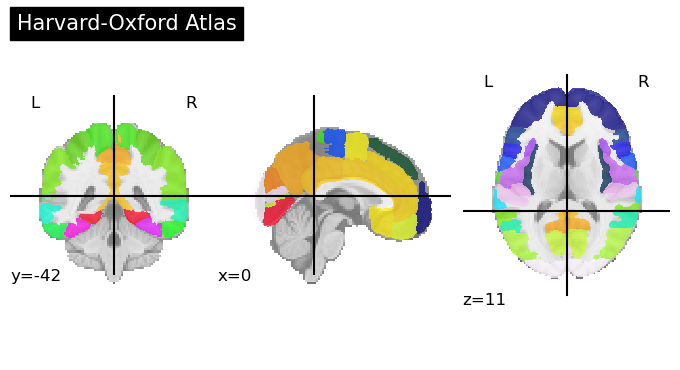

In [2]:
from nilearn import regions

# Load atlas
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')

# Load atlas image and labels
atlas_img = atlas.maps
atlas_labels = atlas.labels

# Show an example of the atlas
from nilearn.plotting import plot_roi

plot_roi(atlas_img, title="Harvard-Oxford Atlas")


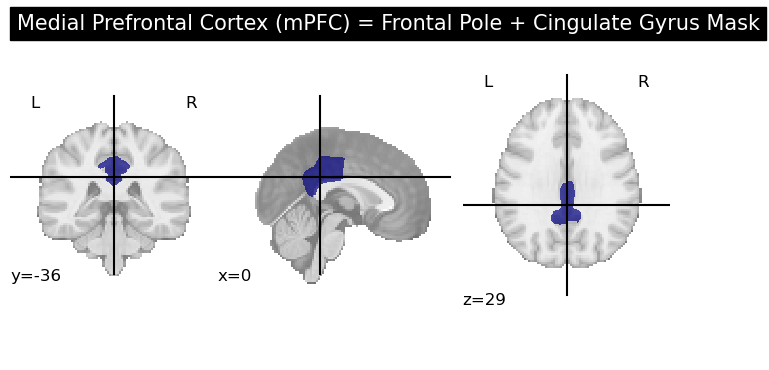

In [40]:
# Find the indices for the medial prefrontal cortex (Frontal Pole & ACC)
mpfc_indices = [i for i, label in enumerate(atlas_labels) if "Frontal Pole" in label or "Cingulate Gyrus, anterior division" in label]

# Combine these masks into one
mpfc_mask = None
for idx in mpfc_indices:
    region_mask = image.math_img(f"img == {idx + 1}", img=atlas_img)
    mpfc_mask = region_mask if mpfc_mask is None else image.math_img("img1 + img2", img1=mpfc_mask, img2=region_mask)

# Plot the mPFC mask
from nilearn.plotting import plot_roi
plot_roi(mpfc_mask, title="Medial Prefrontal Cortex (mPFC) = Frontal Pole + Cingulate Gyrus Mask")


In [5]:
from nilearn.image import resample_to_img

# Load fMRI image
fmri_img = datasets.fetch_development_fmri(n_subjects=1).func[0]

# Resample the mPFC mask to match the fMRI image
mpfc_mask_resampled = resample_to_img(mpfc_mask, fmri_img, interpolation="nearest")

# Apply the mask to extract the signal
mpfc_signal = masking.apply_mask(fmri_img, mpfc_mask_resampled)


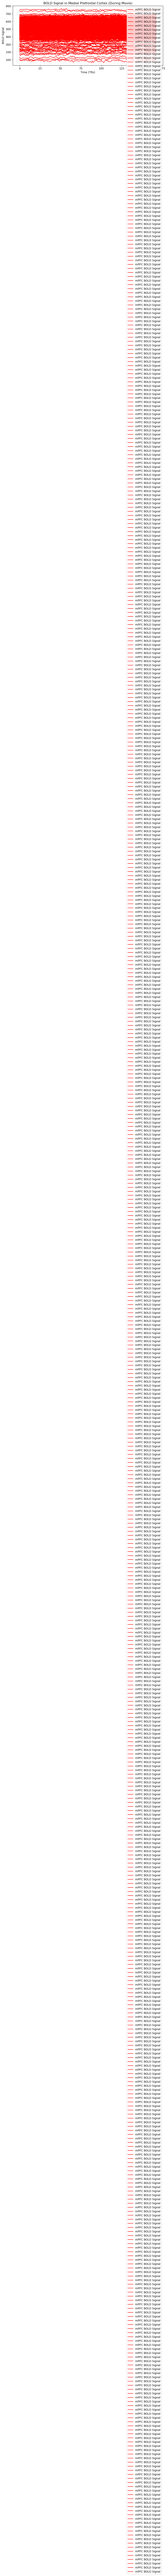

In [7]:
# Extract time series from the mPFC
#fmri_img = datasets.fetch_development_fmri(n_subjects=1).func[0]
#mpfc_signal = masking.apply_mask(fmri_img, mpfc_mask)

# Plot the extracted signal
plt.figure(figsize=(10, 4))
plt.plot(mpfc_signal, label="mPFC BOLD Signal", color="red")
plt.xlabel("Time (TRs)")
plt.ylabel("BOLD Signal")
plt.title("BOLD Signal in Medial Prefrontal Cortex (During Movie)")
plt.legend()
plt.show()

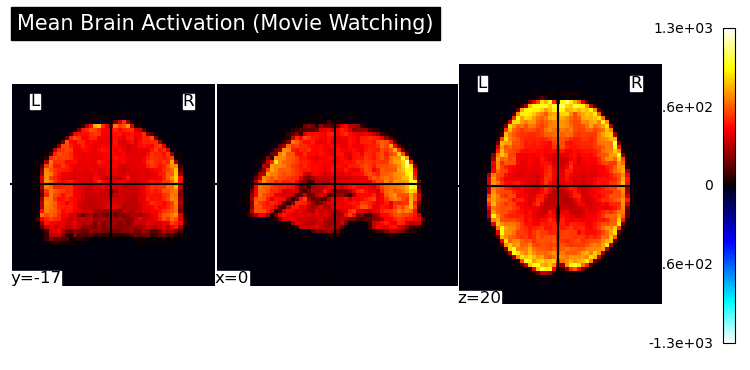

In [8]:
from nilearn.plotting import plot_stat_map

# Compute mean fMRI image
mean_fmri = image.mean_img(fmri_img)

# Plot the mean activation overlaid on the brain
plot_stat_map(mean_fmri, title="Mean Brain Activation (Movie Watching)")


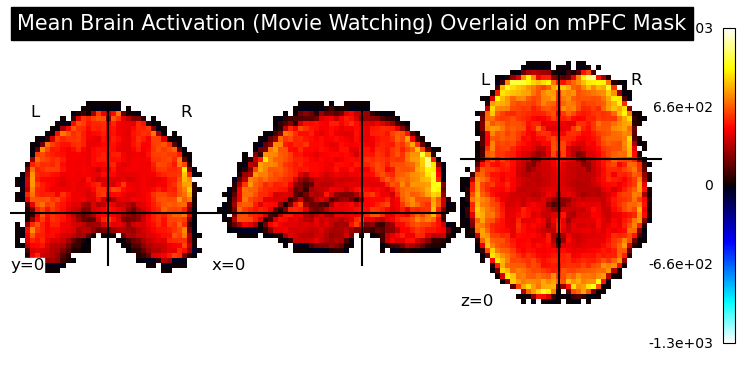

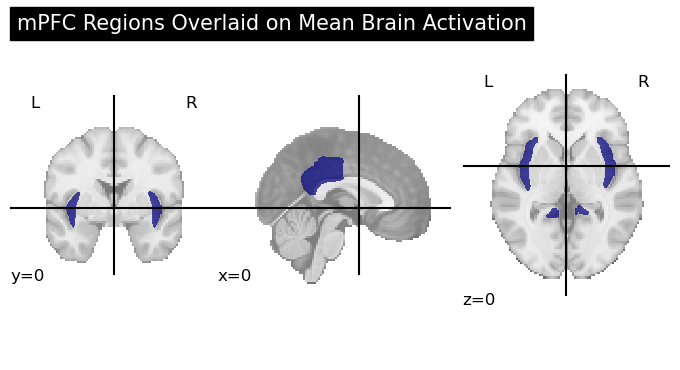

In [44]:
from nilearn.plotting import plot_stat_map

# Compute mean fMRI image
mean_fmri = image.mean_img(fmri_img)

# Plot the mean activation overlaid on the mPFC mask
plot_stat_map(mean_fmri, 
              title="Mean Brain Activation (Movie Watching) Overlaid on mPFC Mask", 
              threshold=5.0,  # Adjust this threshold as needed for visibility
              bg_img=None,  # Background image to use (if None, it'll use a standard brain template)
              display_mode='ortho',  # Adjust display mode to your preference ('ortho' for orthogonal slices)
              draw_cross=True,  # Draw a cross at the center of the image
              cut_coords=(0, 0, 0))  # Adjust coordinates for the cuts, or omit for automatic

# Overlay the mPFC mask on the same plot
plot_roi(mpfc_mask, 
         title="mPFC Regions Overlaid on Mean Brain Activation", 
         display_mode='ortho', 
         draw_cross=True, 
         cut_coords=(0, 0, 0))

In [11]:
# Compute the mean activation over time for mPFC (average BOLD signal)
mpfc_mean_activation = np.mean(mpfc_signal, axis=0)

# Step 5: Compute Whole-Brain Mean Activation
mean_fmri = image.mean_img(fmri_img)

In [12]:

# Optional: Extract a whole-brain time series (or compute a similar summary)
whole_brain_signal = masking.apply_mask(fmri_img, masking.compute_epi_mask(fmri_img))
whole_brain_mean_activation = np.mean(whole_brain_signal, axis=0)


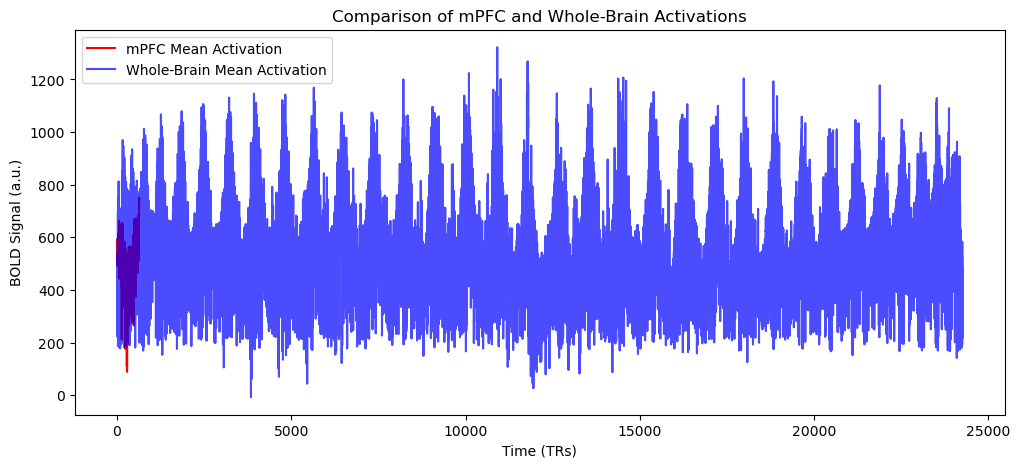

In [13]:
# Step 6: Plot the mPFC and Whole-Brain Activations over Time
plt.figure(figsize=(12, 5))
plt.plot(mpfc_mean_activation, label="mPFC Mean Activation", color="red")
plt.plot(whole_brain_mean_activation, label="Whole-Brain Mean Activation", color="blue", alpha=0.7)
plt.xlabel("Time (TRs)")
plt.ylabel("BOLD Signal (a.u.)")
plt.title("Comparison of mPFC and Whole-Brain Activations")
plt.legend()
plt.show()

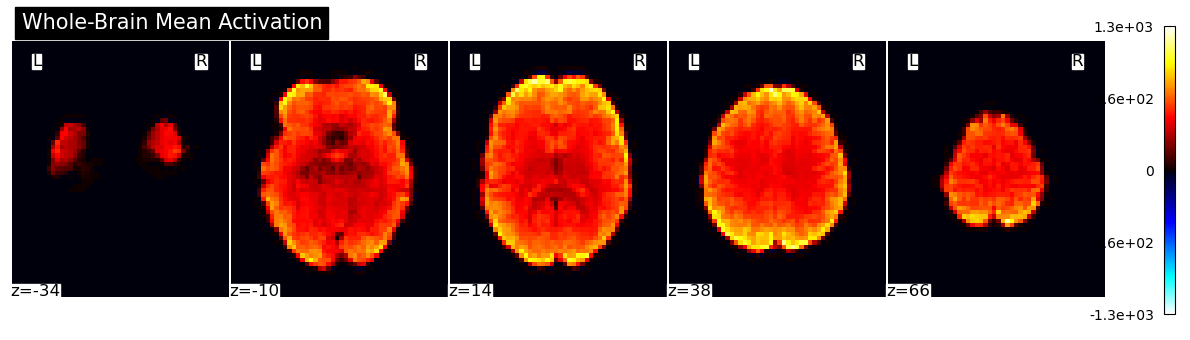

In [14]:

# Step 7: Plot the Mean Whole-Brain Activation as a Statistical Map for Comparison
plot_stat_map(mean_fmri, title="Whole-Brain Mean Activation", display_mode="z", cut_coords=5)

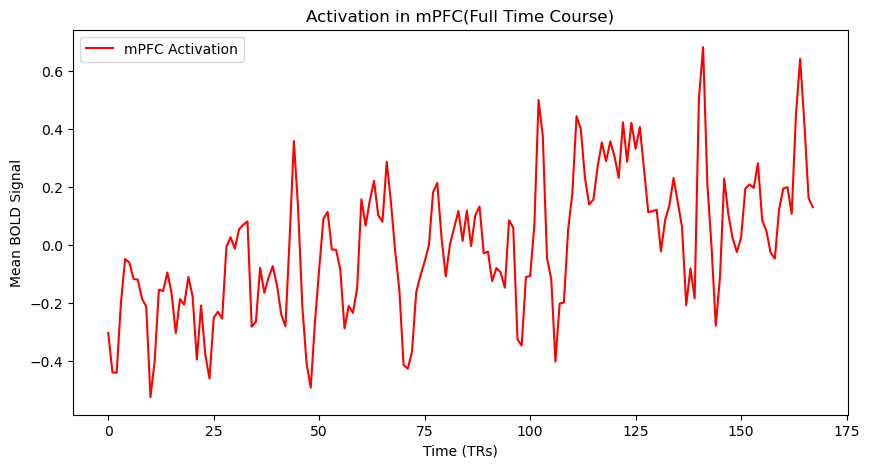

In [18]:
from nilearn.input_data import NiftiMasker

# Use NiftiMasker to extract time series properly
mpfc_masker = NiftiMasker(mask_img=mpfc_mask_resampled, standardize=True)
#motor_masker = NiftiMasker(mask_img=motor_mask_resampled, standardize=True)

mpfc_time_series = mpfc_masker.fit_transform(fmri_img).mean(axis=1)
#motor_time_series = motor_masker.fit_transform(fmri_img).mean(axis=1)

# Plot the full time series for both regions
plt.figure(figsize=(10, 5))
plt.plot(mpfc_time_series, label="mPFC Activation", color="red")
#plt.plot(motor_time_series, label="Motor Cortex Activation", color="blue", linestyle="dashed")
plt.xlabel("Time (TRs)")
plt.ylabel("Mean BOLD Signal")
plt.title("Activation in mPFC(Full Time Course)")
plt.legend()
plt.show()


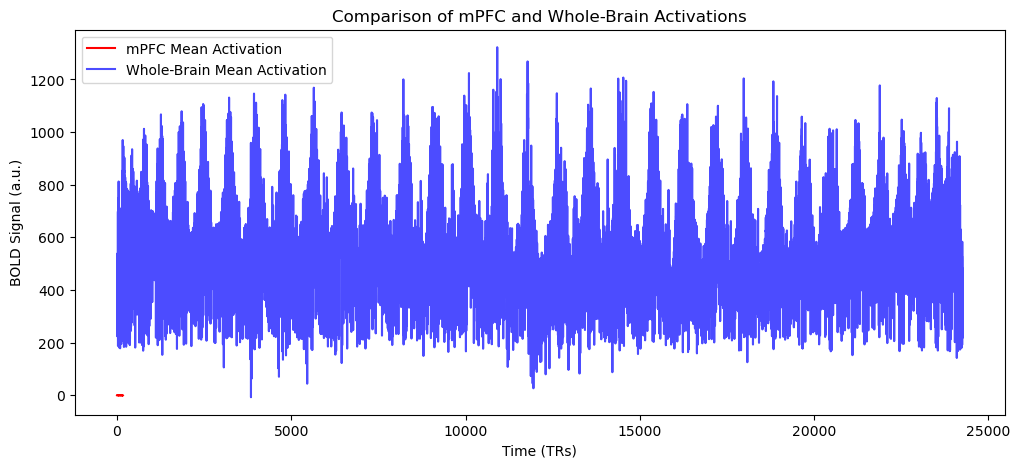

In [19]:
# Step 6: Plot the mPFC and Whole-Brain Activations over Time
plt.figure(figsize=(12, 5))
plt.plot(mpfc_time_series, label="mPFC Mean Activation", color="red")
plt.plot(whole_brain_mean_activation, label="Whole-Brain Mean Activation", color="blue", alpha=0.7)
plt.xlabel("Time (TRs)")
plt.ylabel("BOLD Signal (a.u.)")
plt.title("Comparison of mPFC and Whole-Brain Activations")
plt.legend()
plt.show()

In [21]:
mpfc_time_series.shape

(168,)

In [20]:
from nilearn.glm.first_level import mean_scaling
from nilearn.plotting import plot_stat_map, plot_glass_brain

# Compute mean fMRI image (to use as background)
mean_fmri = image.mean_img(fmri_img)

# Compute voxel-wise activation by taking mean across time
mpfc_activation_img = masking.unmask(mpfc_time_series, mpfc_mask_resampled)

# Rescale for better visualization
mpfc_activation_img = mean_scaling(mpfc_activation_img)

# Plot mPFC activation on anatomical image
plot_stat_map(mpfc_activation_img, mean_fmri, title="mPFC Activation", display_mode="ortho")

# Plot mPFC activation as a glass brain
plot_glass_brain(mpfc_activation_img, title="mPFC Activation (Glass Brain)", colorbar=True, threshold=0.1)


TypeError: X must be of shape (samples, 634).

In [22]:
from nilearn.input_data import NiftiMasker
from nilearn.masking import compute_epi_mask

# Compute whole-brain mask (automatically generated)
whole_brain_mask = compute_epi_mask(fmri_img)

# Create NiftiMaskers for both regions
mpfc_masker = NiftiMasker(mask_img=mpfc_mask_resampled, standardize=True)
whole_brain_masker = NiftiMasker(mask_img=whole_brain_mask, standardize=True)

# Extract time series
mpfc_time_series = mpfc_masker.fit_transform(fmri_img).mean(axis=1)
whole_brain_time_series = whole_brain_masker.fit_transform(fmri_img).mean(axis=1)


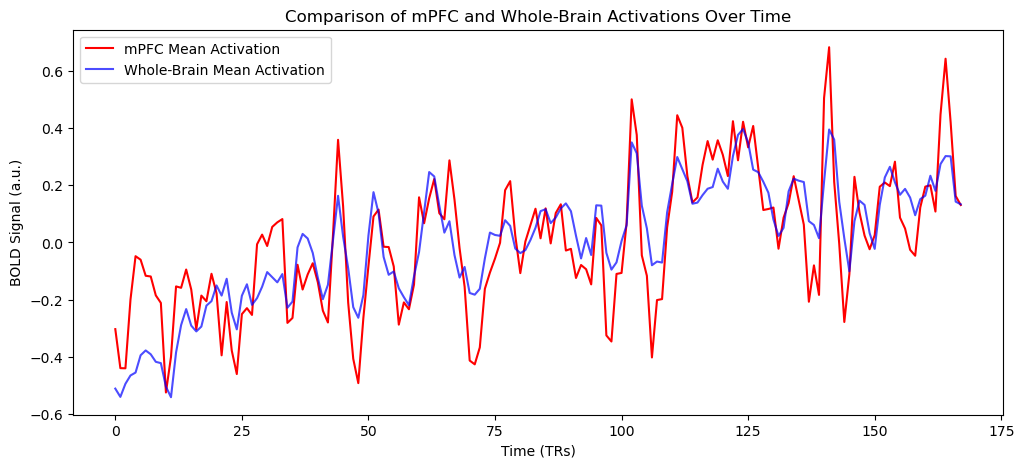

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(mpfc_time_series, label="mPFC Mean Activation", color="red")
plt.plot(whole_brain_time_series, label="Whole-Brain Mean Activation", color="blue", alpha=0.7)
plt.xlabel("Time (TRs)")
plt.ylabel("BOLD Signal (a.u.)")
plt.title("Comparison of mPFC and Whole-Brain Activations Over Time")
plt.legend()
plt.show()


In [25]:
mpfc_time_series.shape

(168,)

In [26]:
import numpy as np

# Compute mean activation per voxel (across time)
mpfc_voxel_activation = np.mean(mpfc_masker.fit_transform(fmri_img), axis=0)

# Check shape to ensure it's voxel-wise (should match number of voxels in mask)
print(mpfc_voxel_activation.shape)  


(634,)


In [29]:
from nilearn import masking, image, plotting
from nilearn.glm.first_level import mean_scaling

# Compute mean fMRI image (background reference)
mean_fmri = image.mean_img(fmri_img)

# Map time series back into 3D brain space
mpfc_activation_img = masking.unmask(mpfc_voxel_activation, mpfc_mask_resampled)

from nilearn.image import get_data

# Convert Nifti1Image to a NumPy array
mpfc_activation_data = get_data(mpfc_activation_img)

# Now apply mean scaling
mpfc_activation_scaled = mean_scaling(mpfc_activation_data)


# Scale activation for better visualization
#mpfc_activation_img = mean_scaling(mpfc_activation_img)


C:\Users\victo\AppData\Local\Temp\ipykernel_24900\2256502362.py:16: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  mpfc_activation_scaled = mean_scaling(mpfc_activation_data)


In [30]:
from nilearn.image import new_img_like

mpfc_activation_scaled_img = new_img_like(mpfc_activation_img, mpfc_activation_scaled)


AttributeError: 'tuple' object has no attribute 'dtype'

In [32]:
mpfc_activation_data.dtype

dtype('float64')

In [35]:
print(np.min(mpfc_activation_scaled_data[0]), np.max(mpfc_activation_scaled_data[0]))


-100.00000000000145 -99.99999999999855


In [37]:
import numpy as np

vmin = np.min(mpfc_activation_scaled_data[0])
vmax = np.max(mpfc_activation_scaled_data[0])


In [38]:
from nilearn.image import new_img_like, get_data
from nilearn.plotting import plot_glass_brain
import numpy as np

# Assuming 'mpfc_activation_img' is your original NIfTI image (mPFC activation)
mpfc_activation_data = get_data(mpfc_activation_img)  # Convert to NumPy array

# Apply mean scaling (this should return a NumPy array)
mpfc_activation_scaled_data = mean_scaling(mpfc_activation_data)

# Check if the scaling returned a tuple or an array
print(f"Scaled data type: {type(mpfc_activation_scaled_data)}")  # Should be <class 'numpy.ndarray'>

# Create a new NIfTI image using the scaled data
mpfc_activation_scaled_img = new_img_like(mpfc_activation_img, mpfc_activation_scaled_data[0])

# Plot the glass brain with the scaled data
plot_glass_brain(mpfc_activation_scaled_img, colorbar=True, threshold=0.5, display_mode='lyrz', cmap='cold_hot')


C:\Users\victo\AppData\Local\Temp\ipykernel_24900\1903412061.py:9: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  mpfc_activation_scaled_data = mean_scaling(mpfc_activation_data)


Scaled data type: <class 'tuple'>


ValueError: minvalue must be less than or equal to maxvalue

Error in callback <function _draw_all_if_interactive at 0x00000288F660EEF0> (for post_execute):


ValueError: minvalue must be less than or equal to maxvalue

ValueError: minvalue must be less than or equal to maxvalue

<Figure size 950x350 with 6 Axes>

In [31]:
from nilearn.image import new_img_like
from nilearn.image import get_data
import numpy as np

# Assuming 'mpfc_activation_data' is the numpy array version of the activation data
mpfc_activation_scaled_data = mean_scaling(mpfc_activation_data)

# Check the type to ensure it's a NumPy array
print(type(mpfc_activation_scaled_data))  # It should be a numpy ndarray

# Create the NIfTI image again with the correct data
mpfc_activation_scaled_img = new_img_like(mpfc_activation_img, mpfc_activation_scaled_data)

# Now plot the glass brain
from nilearn.plotting import plot_glass_brain
plot_glass_brain(mpfc_activation_scaled_img, colorbar=True, threshold=0.5, display_mode='lyrz', cmap='cold_hot')


<class 'tuple'>


C:\Users\victo\AppData\Local\Temp\ipykernel_24900\281927589.py:6: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  mpfc_activation_scaled_data = mean_scaling(mpfc_activation_data)


AttributeError: 'tuple' object has no attribute 'dtype'